In [3]:
# cell 1 
import os

path = "/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"
print(os.listdir(path))

['records500', 'SHA256SUMS.txt', 'RECORDS', 'example_physionet.py', 'scp_statements.csv', 'ptbxl_database.csv', 'LICENSE.txt', 'records100']

# KIỂM TRA THƯ MỤC
# ===========================
# CÀI THƯ VIỆN
# ===========================
!pip install wfdb --quiet
!pip install tqdm --quiet

# ===========================
# IMPORT
# ===========================
import os
import wfdb
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import ast

# ===========================
# ĐƯỜNG DẪN DATA CHUẨN
# ===========================
DATA_PATH = "/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"
CSV_PATH = DATA_PATH + "/ptbxl_database.csv"
SCP_PATH = DATA_PATH + "/scp_statements.csv"

# ===========================
# ĐỌC METADATA
# ===========================
df = pd.read_csv(CSV_PATH)
scp_df = pd.read_csv(SCP_PATH, index_col=0)

print("Tổng record ban đầu:", len(df))

# ===========================
# GIỮ LẠI 5 NHÓM BỆNH QUAN TRỌNG
# ===========================
valid_classes = ["NORM", "MI", "STTC", "CD", "HYP"]

def extract_class(codes):
    try:
        codes_dict = ast.literal_eval(codes)
    except:
        return None
    for c in codes_dict:
        if c in scp_df.index:
            cls = scp_df.loc[c, "diagnostic_class"]
            if cls in valid_classes:
                return cls
    return None

df["label"] = df["scp_codes"].apply(extract_class)
df = df.dropna(subset=["label"])

print("Record có nhãn thuộc 5 nhóm:", len(df))
print(df["label"].value_counts())

# ===========================
# KIỂM TRA FILE BỊ LỖI / KHÔNG ĐỌC ĐƯỢC
# ===========================
valid_records = []
invalid_records = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    fname = row["filename_lr"]
    full_path = os.path.join(DATA_PATH, fname)

    if not os.path.isfile(full_path + ".dat") or not os.path.isfile(full_path + ".hea"):
        invalid_records.append(idx)
        continue

    try:
        wfdb.rdsamp(full_path)
        valid_records.append(idx)
    except:
        invalid_records.append(idx)

print("Record lỗi – loại bỏ:", len(invalid_records))
print("Record hợp lệ:", len(valid_records))

df = df.loc[valid_records].reset_index(drop=True)

# ===========================
# CHIA TRAIN / TEST 80/20
# ===========================
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

# ===========================
# LƯU FILE LIST KẾT QUẢ
# ===========================
train_df.to_csv("ptbxl_train_split.csv", index=False)
test_df.to_csv("ptbxl_test_split.csv", index=False)

print("✔ Đã lưu ptbxl_train_split.csv và ptbxl_test_split.csv thành công!")

['records500', 'SHA256SUMS.txt', 'RECORDS', 'example_physionet.py', 'scp_statements.csv', 'ptbxl_database.csv', 'LICENSE.txt', 'records100']
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 116.2 MB/s eta 0:00:0000:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1

100%|██████████| 21430/21430 [05:07<00:00, 69.64it/s]


Record lỗi – loại bỏ: 0
Record hợp lệ: 21430
Train size: 17144
Test size: 4286
✔ Đã lưu ptbxl_train_split.csv và ptbxl_test_split.csv thành công!


In [4]:
# cell 2
# KIỂM TRA DỮ LIỆU 
import wfdb
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

DATA_PATH = "/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"

# Đọc lại file chia train/test
train_df = pd.read_csv("ptbxl_train_split.csv")
test_df = pd.read_csv("ptbxl_test_split.csv")

# Danh sách để lưu lỗi
missing_files = []
cannot_read = []
wrong_shape = []
nan_inf = []
length_issue = []

def check_record(record_name):
    full_path = os.path.join(DATA_PATH, record_name)

    # Kiểm tra file tồn tại
    if not os.path.isfile(full_path + ".dat") or not os.path.isfile(full_path + ".hea"):
        missing_files.append(record_name)
        return
    
    # Kiểm tra đọc file
    try:
        sig, fields = wfdb.rdsamp(full_path)
    except:
        cannot_read.append(record_name)
        return
    
    # Kiểm tra số kênh phải = 12
    if sig.shape[1] != 12:
        wrong_shape.append(record_name)
    
    # Kiểm tra NaN hoặc Inf
    if np.isnan(sig).any() or np.isinf(sig).any():
        nan_inf.append(record_name)
    
    # Kiểm tra length hợp lệ (thông thường 1000 sample cho records100)
    if sig.shape[0] < 800 or sig.shape[0] > 1200:
        length_issue.append(record_name)

# Gộp 2 tập train + test để kiểm tra toàn bộ dataset đã lọc
check_df = pd.concat([train_df, test_df]).reset_index(drop=True)

print("Tổng số record cần kiểm tra:", len(check_df))

for i in tqdm(range(len(check_df))):
    check_record(check_df.loc[i, "filename_lr"])

# ======= KẾT QUẢ =======

print("\n=== KẾT QUẢ KIỂM TRA DỮ LIỆU ===")
print("Missing files:", len(missing_files))
print("Cannot read WFDB:", len(cannot_read))
print("Wrong channel shape:", len(wrong_shape))
print("NaN/Inf values:", len(nan_inf))
print("Length issue:", len(length_issue))

# Lưu danh sách lỗi nếu có
pd.DataFrame({"missing_files": missing_files}).to_csv("error_missing_files.csv", index=False)
pd.DataFrame({"cannot_read": cannot_read}).to_csv("error_cannot_read.csv", index=False)
pd.DataFrame({"wrong_shape": wrong_shape}).to_csv("error_wrong_shape.csv", index=False)
pd.DataFrame({"nan_inf": nan_inf}).to_csv("error_nan_inf.csv", index=False)
pd.DataFrame({"length_issue": length_issue}).to_csv("error_length_issue.csv", index=False)

print("\n✔ Đã hoàn tất kiểm tra dữ liệu. Nếu không lỗi → Dataset hoàn hảo!")

Tổng số record cần kiểm tra: 21430


100%|██████████| 21430/21430 [01:34<00:00, 226.19it/s]


=== KẾT QUẢ KIỂM TRA DỮ LIỆU ===
Missing files: 0
Cannot read WFDB: 0
Wrong channel shape: 0
NaN/Inf values: 0
Length issue: 0

✔ Đã hoàn tất kiểm tra dữ liệu. Nếu không lỗi → Dataset hoàn hảo!


In [5]:
# cell 3
!pip install PyWavelets --quiet

In [6]:
# cell 4
import pywt


In [7]:
# Cell 5: Import các thư viện cần thiết (bỏ imblearn để tránh lỗi)
import pywt
import  h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
# from imblearn.over_sampling import SMOTE  # <-- XÓA DÒNG NÀY
# from imblearn.under_sampling import RandomUnderSampler  # <-- XÓA
# from imblearn.pipeline import Pipeline  # <-- XÓA
from sklearn.utils.class_weight import compute_class_weight  # Giữ để tính weights
import gc


In [8]:
# cell 6

import pandas as pd

df_train = pd.read_csv("ptbxl_train_split.csv")
df_test = pd.read_csv("ptbxl_test_split.csv")

print(df_train.shape, df_test.shape)
df_train.head()


(17144, 29) (4286, 29)


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,label
0,11631,18011.0,27.0,1,NaN,NaN,0.0,0.0,CS100 3,1994-01-11 12:00:14,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/11000/11631_lr,records500/11000/11631_hr,NORM
1,11728,398.0,69.0,1,160.0,90.0,10.0,1.0,AT-6 C 5.8,1994-01-26 10:14:23,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/11000/11728_lr,records500/11000/11728_hr,CD
2,8239,6112.0,53.0,0,170.0,70.0,5.0,1.0,AT-6 C 5.5,1992-06-19 15:12:55,...,NaN,NaN,NaN,NaN,NaN,NaN,3,records100/08000/08239_lr,records500/08000/08239_hr,NORM
3,17432,15151.0,62.0,0,NaN,NaN,1.0,2.0,CS-12,1997-01-05 17:19:51,...,NaN,", I,II,",NaN,NaN,NaN,NaN,3,records100/17000/17432_lr,records500/17000/17432_hr,NORM
4,341,5779.0,71.0,1,170.0,55.0,3.0,1.0,AT-6 C 5.5,1986-09-19 18:47:52,...,NaN,NaN,NaN,NaN,NaN,NaN,3,records100/00000/00341_lr,records500/00000/00341_hr,STTC


In [9]:
# cell 7

label_mapping = {
    "NORM": 0,
    "MI": 1,
    "STTC": 2,
    "CD": 3,
    "HYP": 4
}

df_train["target"] = df_train["label"].map(label_mapping)
df_test["target"]  = df_test["label"].map(label_mapping)

df_train["target"].value_counts()


target
0    7622
1    4353
2    2258
3    1862
4    1049
Name: count, dtype: int64

In [10]:
# Cell 8

import wfdb
import numpy as np
import pandas as pd
import os

BASE = "/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"

def load_ecg(filename_hr):
    path = os.path.join(BASE, filename_hr.replace(".hea", ""))
    sig, fields = wfdb.rdsamp(path)
    return sig.astype(np.float32)


In [11]:
# Cell 9: Preprocess_ecg tối ưu (tắt aug, xử lý NaN triệt để)
def preprocess_ecg(ecg, apply_augmentation=False):
    processed = np.zeros_like(ecg, dtype=np.float32)
    
    for lead in range(12):
        denoised = wavelet_denoise(ecg[:, lead])
        filtered = bandpass_filter(denoised)
        processed[:, lead] = filtered
    
    # Xử lý NaN/Inf ngay
    processed = np.nan_to_num(processed, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Normalize an toàn
    mean = processed.mean(axis=0)
    std = processed.std(axis=0)
    std = np.where(std == 0, 1.0, std)  # Tránh chia 0
    processed = (processed - mean) / std
    
    processed = np.nan_to_num(processed, nan=0.0)
    
    # TẮT AUGMENTATION ĐỂ TRAIN ỔN ĐỊNH
    # if apply_augmentation:
    #     processed = augment_ecg(processed)
    
    return processed

In [12]:
# Cell 10 : Tạo cột 'target' (nhãn số) cho df_train và df_test (tự load nếu mất biến)
import pandas as pd

label_mapping = {"NORM": 0, "MI": 1, "STTC": 2, "CD": 3, "HYP": 4}

# Load lại df_train và df_test từ file CSV đã lưu (an toàn nếu kernel reset)
try:
    df_train = pd.read_csv("ptbxl_train_split.csv")
    df_test = pd.read_csv("ptbxl_test_split.csv")
    print("Đã load df_train và df_test từ CSV.")
except:
    print("Lỗi load CSV - chạy lại cell chia train/test trước!")

# Tạo cột 'target' nếu chưa có
if 'target' not in df_train.columns:
    df_train['target'] = df_train['label'].map(label_mapping)
if 'target' not in df_test.columns:
    df_test['target'] = df_test['label'].map(label_mapping)

print("df_train shape:", df_train.shape)
print("df_test shape:", df_test.shape)
print("Sample target train:", df_train[['label', 'target']].head())
print("Phân bố target train:", df_train['target'].value_counts().sort_index())

Đã load df_train và df_test từ CSV.
df_train shape: (17144, 30)
df_test shape: (4286, 30)
Sample target train:   label  target
0  NORM       0
1    CD       3
2  NORM       0
3  NORM       0
4  STTC       2
Phân bố target train: target
0    7622
1    4353
2    2258
3    1862
4    1049
Name: count, dtype: int64


In [13]:
# Cell 11: Load và preprocess toàn bộ dữ liệu, lưu vào HDF5 (gộp đầy đủ hàm để tránh lỗi)
import h5py
import gc
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import pywt

# === GỘP TẤT CẢ HÀM CẦN THIẾT VÀO ĐÂY ===
def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [coeffs[0]]
    for detail in coeffs[1:]:
        denoised_coeffs.append(pywt.threshold(detail, threshold, mode='soft'))
    reconstructed = pywt.waverec(denoised_coeffs, wavelet)
    return reconstructed[:len(signal)]

def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=500, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def augment_ecg(ecg):
    augmented = ecg.copy()
    if np.random.rand() < 0.7:
        shift = np.random.randint(-100, 100)
        augmented = np.roll(augmented, shift, axis=0)
    if np.random.rand() < 0.7:
        noise = np.random.normal(0, 0.02, augmented.shape)
        augmented += noise
    if np.random.rand() < 0.7:
        scale = np.random.uniform(0.8, 1.2)
        augmented *= scale
    return augmented

def preprocess_ecg(ecg, apply_augmentation=False):
    processed = np.zeros_like(ecg, dtype=np.float32)
    
    for lead in range(12):
        denoised = wavelet_denoise(ecg[:, lead])
        filtered = bandpass_filter(denoised)
        processed[:, lead] = filtered
    
    # Xử lý NaN/Inf triệt để
    processed = np.nan_to_num(processed, nan=0.0, posinf=0.0, neginf=0.0)
    
    mean = processed.mean(axis=0)
    std = processed.std(axis=0)
    std = np.where(std == 0, 1.0, std)
    processed = (processed - mean) / std
    
    processed = np.nan_to_num(processed, nan=0.0)
    
    if apply_augmentation:
        processed = augment_ecg(processed)
    
    return processed
# === KẾT THÚC GỘP HÀM ===

# Đảm bảo df_train và df_test có cột 'target'
label_mapping = {"NORM": 0, "MI": 1, "STTC": 2, "CD": 3, "HYP": 4}

# Load lại df nếu mất (an toàn)
try:
    df_train = pd.read_csv("ptbxl_train_split.csv")
    df_test = pd.read_csv("ptbxl_test_split.csv")
    print("Đã load df_train và df_test từ CSV.")
except:
    print("Lỗi load CSV - chạy lại cell chia train/test!")

# Tạo cột 'target'
if 'target' not in df_train.columns:
    df_train['target'] = df_train['label'].map(label_mapping)
if 'target' not in df_test.columns:
    df_test['target'] = df_test['label'].map(label_mapping)

print("df_train shape:", df_train.shape)
print("df_test shape:", df_test.shape)

# Hàm lưu processed
def save_processed_data(df, filename, apply_aug=False, batch_size=500):
    total = len(df)
    with h5py.File(filename, 'w') as f:
        ecg_dataset = f.create_dataset('ecgs', (total, 5000, 12), dtype='float32')
        label_dataset = f.create_dataset('labels', (total,), dtype='int32')
        
        for start_idx in range(0, total, batch_size):
            end_idx = min(start_idx + batch_size, total)
            batch_df = df.iloc[start_idx:end_idx]
            
            batch_ecgs = []
            batch_labels = []
            
            for _, row in batch_df.iterrows():
                ecg_raw = load_ecg(row['filename_hr'])
                ecg_processed = preprocess_ecg(ecg_raw, apply_augmentation=apply_aug)
                batch_ecgs.append(ecg_processed)
                batch_labels.append(row['target'])
            
            ecg_dataset[start_idx:end_idx] = np.array(batch_ecgs)
            label_dataset[start_idx:end_idx] = np.array(batch_labels)
            
            print(f"Processed {end_idx}/{total} records for {filename}")
            gc.collect()
    
    print(f"Đã lưu {filename}")

# Chạy lưu
save_processed_data(df_train, 'ptbxl_train_processed.h5', apply_aug=True)
save_processed_data(df_test, 'ptbxl_test_processed.h5', apply_aug=False)

Đã load df_train và df_test từ CSV.
df_train shape: (17144, 30)
df_test shape: (4286, 30)
Processed 500/17144 records for ptbxl_train_processed.h5
Processed 1000/17144 records for ptbxl_train_processed.h5
Processed 1500/17144 records for ptbxl_train_processed.h5
Processed 2000/17144 records for ptbxl_train_processed.h5
Processed 2500/17144 records for ptbxl_train_processed.h5
Processed 3000/17144 records for ptbxl_train_processed.h5
Processed 3500/17144 records for ptbxl_train_processed.h5
Processed 4000/17144 records for ptbxl_train_processed.h5
Processed 4500/17144 records for ptbxl_train_processed.h5
Processed 5000/17144 records for ptbxl_train_processed.h5
Processed 5500/17144 records for ptbxl_train_processed.h5
Processed 6000/17144 records for ptbxl_train_processed.h5
Processed 6500/17144 records for ptbxl_train_processed.h5
Processed 7000/17144 records for ptbxl_train_processed.h5
Processed 7500/17144 records for ptbxl_train_processed.h5
Processed 8000/17144 records for ptbxl_tr

/usr/local/lib/python3.12/dist-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


Processed 15000/17144 records for ptbxl_train_processed.h5
Processed 15500/17144 records for ptbxl_train_processed.h5
Processed 16000/17144 records for ptbxl_train_processed.h5
Processed 16500/17144 records for ptbxl_train_processed.h5
Processed 17000/17144 records for ptbxl_train_processed.h5
Processed 17144/17144 records for ptbxl_train_processed.h5
Đã lưu ptbxl_train_processed.h5
Processed 500/4286 records for ptbxl_test_processed.h5
Processed 1000/4286 records for ptbxl_test_processed.h5
Processed 1500/4286 records for ptbxl_test_processed.h5
Processed 2000/4286 records for ptbxl_test_processed.h5
Processed 2500/4286 records for ptbxl_test_processed.h5
Processed 3000/4286 records for ptbxl_test_processed.h5
Processed 3500/4286 records for ptbxl_test_processed.h5
Processed 4000/4286 records for ptbxl_test_processed.h5
Processed 4286/4286 records for ptbxl_test_processed.h5
Đã lưu ptbxl_test_processed.h5


In [14]:
# Cell 12: Tính class weights + Cân bằng bằng augmentation thủ công (đã gộp preprocess_ecg để tránh lỗi)
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import h5py
import pywt
from scipy.signal import butter, filtfilt
import gc

# === GỘP HÀM PREPROCESS_ECG VÀO ĐÂY ĐỂ TRÁNH LỖI ===
def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [coeffs[0]]
    for detail in coeffs[1:]:
        denoised_coeffs.append(pywt.threshold(detail, threshold, mode='soft'))
    return pywt.waverec(denoised_coeffs, wavelet)[:len(signal)]

def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=500, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def augment_ecg(ecg):
    augmented = ecg.copy()
    if np.random.rand() < 0.7:
        shift = np.random.randint(-100, 100)
        augmented = np.roll(augmented, shift, axis=0)
    if np.random.rand() < 0.7:
        noise = np.random.normal(0, 0.02, augmented.shape)
        augmented += noise
    if np.random.rand() < 0.7:
        scale = np.random.uniform(0.8, 1.2)
        augmented *= scale
    return augmented

def preprocess_ecg(ecg, apply_augmentation=False):
    processed = np.zeros_like(ecg, dtype=np.float32)
    for lead in range(12):
        denoised = wavelet_denoise(ecg[:, lead])
        filtered = bandpass_filter(denoised)
        processed[:, lead] = filtered
    mean = processed.mean(axis=0)
    std = processed.std(axis=0)
    std[std == 0] = 1e-8
    processed = (processed - mean) / std
    if apply_augmentation:
        processed = augment_ecg(processed)
    return processed
# === KẾT THÚC GỘP HÀM ===

# Tính class weights
classes = np.arange(5)
with h5py.File('ptbxl_train_processed.h5', 'r') as f:
    y_temp = f['labels'][:]
class_weights = compute_class_weight('balanced', classes=classes, y=y_temp)
class_weight_dict = {i: float(w) for i, w in enumerate(class_weights)}
print("Class weights cho training:", class_weight_dict)
np.save('class_weight_dict.npy', class_weight_dict)
print("Đã lưu class_weight_dict.npy")

# Load dữ liệu
with h5py.File('ptbxl_train_processed.h5', 'r') as f:
    X_train = f['ecgs'][:]
    y_train = f['labels'][:]

print("Shape trước cân bằng:", X_train.shape)
print("Phân bố trước:", np.bincount(y_train))

# Augmentation thủ công
X_aug = []
y_aug = []
aug_times = {0: 1, 1: 2, 2: 3, 3: 3, 4: 5}

for i in range(len(X_train)):
    ecg = X_train[i]
    label = y_train[i]
    
    X_aug.append(ecg)
    y_aug.append(label)
    
    for _ in range(aug_times.get(label, 1)):
        aug_ecg = preprocess_ecg(ecg, apply_augmentation=True)
        X_aug.append(aug_ecg)
        y_aug.append(label)
    
    # Dọn RAM định kỳ để tránh treo
    if (i + 1) % 1000 == 0:
        print(f"Đã xử lý {i+1}/{len(X_train)} samples...")
        gc.collect()

X_balanced = np.array(X_aug, dtype=np.float32)
y_balanced = np.array(y_aug, dtype=np.int32)

print("Shape sau cân bằng:", X_balanced.shape)
print("Phân bố lớp sau cân bằng:\n", np.bincount(y_balanced))

# Lưu file cân bằng
with h5py.File('ptbxl_train_balanced.h5', 'w') as f:
    f.create_dataset('ecgs', data=X_balanced)
    f.create_dataset('labels', data=y_balanced)

print("Đã lưu dữ liệu train cân bằng: ptbxl_train_balanced.h5")

Class weights cho training: {0: 0.4498556809236421, 1: 0.7876866528830692, 2: 1.5185119574844996, 3: 1.8414607948442534, 4: 3.2686367969494756}
Đã lưu class_weight_dict.npy
Shape trước cân bằng: (17144, 5000, 12)
Phân bố trước: [7622 4353 2258 1862 1049]
Đã xử lý 1000/17144 samples...
Đã xử lý 2000/17144 samples...
Đã xử lý 3000/17144 samples...
Đã xử lý 4000/17144 samples...
Đã xử lý 5000/17144 samples...
Đã xử lý 6000/17144 samples...
Đã xử lý 7000/17144 samples...
Đã xử lý 8000/17144 samples...
Đã xử lý 9000/17144 samples...
Đã xử lý 10000/17144 samples...
Đã xử lý 11000/17144 samples...
Đã xử lý 12000/17144 samples...
Đã xử lý 13000/17144 samples...
Đã xử lý 14000/17144 samples...


/usr/local/lib/python3.12/dist-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


Đã xử lý 15000/17144 samples...
Đã xử lý 16000/17144 samples...
Đã xử lý 17000/17144 samples...
Shape sau cân bằng: (51077, 5000, 12)
Phân bố lớp sau cân bằng:
 [15244 13059  9032  7448  6294]
Đã lưu dữ liệu train cân bằng: ptbxl_train_balanced.h5


In [15]:
# Cell 13: Extract wavelet features theo batch (an toàn RAM, không die kernel)
import h5py
import pywt
import numpy as np
import gc

def extract_wavelet_features(ecg, wavelet='db6', level=5):
    features = []
    for lead in range(12):
        coeffs = pywt.wavedec(ecg[:, lead], wavelet, level=level)
        for c in coeffs:
            features.extend([np.mean(c), np.std(c), np.sum(c**2)])
    return np.array(features, dtype=np.float32)

# Extract train features theo batch
print("Bắt đầu extract features từ train balanced (51k samples) theo batch...")
batch_size = 500  # An toàn RAM
num_samples = 51077  # Số samples balanced
feature_dim = 216  # 12 leads * 6 coeffs * 3 stats

X_features_train = np.zeros((num_samples, feature_dim), dtype=np.float32)

with h5py.File('ptbxl_train_balanced.h5', 'r') as f:
    ecgs = f['ecgs']
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_ecgs = ecgs[start:end]
        for i in range(end - start):
            X_features_train[start + i] = extract_wavelet_features(batch_ecgs[i])
        print(f"Extracted train {end}/{num_samples}")
        gc.collect()  # Dọn RAM

np.save('train_wavelet_features.npy', X_features_train)
print("Features train shape:", X_features_train.shape)
print("Đã lưu train_wavelet_features.npy")

# Extract test features theo batch
print("Bắt đầu extract features từ test...")
with h5py.File('ptbxl_test_processed.h5', 'r') as f:
    num_test = f['ecgs'].shape[0]
    X_features_test = np.zeros((num_test, feature_dim), dtype=np.float32)
    ecgs = f['ecgs']
    for start in range(0, num_test, batch_size):
        end = min(start + batch_size, num_test)
        batch_ecgs = ecgs[start:end]
        for i in range(end - start):
            X_features_test[start + i] = extract_wavelet_features(batch_ecgs[i])
        print(f"Extracted test {end}/{num_test}")
        gc.collect()

np.save('test_wavelet_features.npy', X_features_test)
print("Features test shape:", X_features_test.shape)
print("Đã lưu test_wavelet_features.npy")

print("Extract features hoàn tất an toàn!")

Bắt đầu extract features từ train balanced (51k samples) theo batch...
Extracted train 500/51077
Extracted train 1000/51077
Extracted train 1500/51077
Extracted train 2000/51077
Extracted train 2500/51077
Extracted train 3000/51077
Extracted train 3500/51077
Extracted train 4000/51077
Extracted train 4500/51077
Extracted train 5000/51077
Extracted train 5500/51077
Extracted train 6000/51077
Extracted train 6500/51077
Extracted train 7000/51077
Extracted train 7500/51077
Extracted train 8000/51077
Extracted train 8500/51077
Extracted train 9000/51077
Extracted train 9500/51077
Extracted train 10000/51077
Extracted train 10500/51077
Extracted train 11000/51077
Extracted train 11500/51077
Extracted train 12000/51077
Extracted train 12500/51077
Extracted train 13000/51077
Extracted train 13500/51077
Extracted train 14000/51077
Extracted train 14500/51077
Extracted train 15000/51077
Extracted train 15500/51077
Extracted train 16000/51077
Extracted train 16500/51077
Extracted train 17000/510

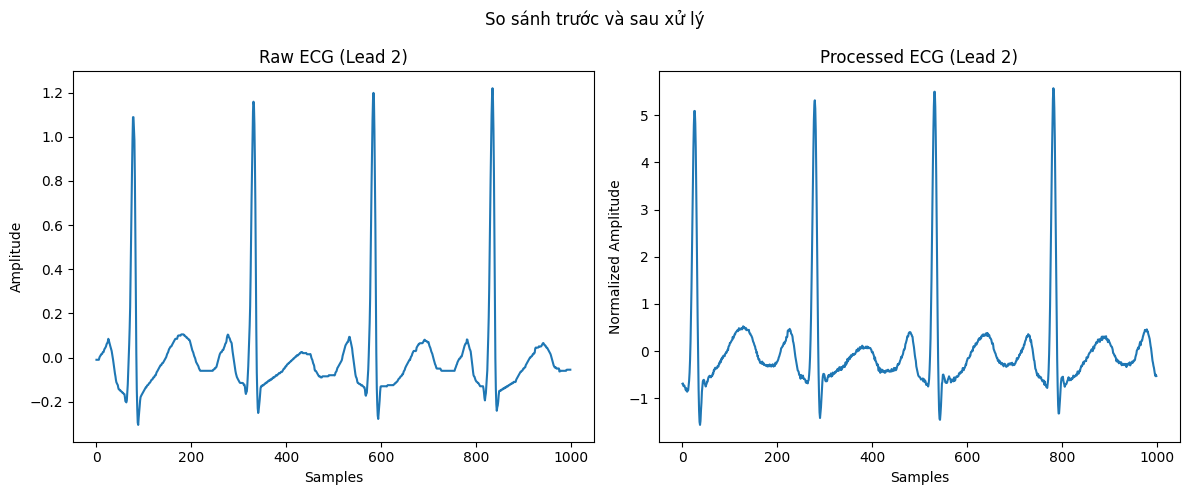

Visualization hoàn tất!


In [16]:
 # Cell 14: Visualization (gộp đầy đủ hàm để tránh lỗi NameError)
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pywt

BASE = "/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"

def load_ecg(filename_hr):
    path = os.path.join(BASE, filename_hr.replace(".hea", ""))
    sig, fields = wfdb.rdsamp(path)
    return sig.astype(np.float32)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [coeffs[0]]
    for detail in coeffs[1:]:
        denoised_coeffs.append(pywt.threshold(detail, threshold, mode='soft'))
    return pywt.waverec(denoised_coeffs, wavelet)[:len(signal)]

def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=500, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def augment_ecg(ecg):
    augmented = ecg.copy()
    if np.random.rand() < 0.7:
        shift = np.random.randint(-100, 100)
        augmented = np.roll(augmented, shift, axis=0)
    if np.random.rand() < 0.7:
        noise = np.random.normal(0, 0.02, augmented.shape)
        augmented += noise
    if np.random.rand() < 0.7:
        scale = np.random.uniform(0.8, 1.2)
        augmented *= scale
    return augmented

def preprocess_ecg(ecg, apply_augmentation=False):
    processed = np.zeros_like(ecg, dtype=np.float32)
    for lead in range(12):
        denoised = wavelet_denoise(ecg[:, lead])
        filtered = bandpass_filter(denoised)
        processed[:, lead] = filtered
    processed = np.nan_to_num(processed, nan=0.0, posinf=0.0, neginf=0.0)
    mean = processed.mean(axis=0)
    std = processed.std(axis=0)
    std[std == 0] = 1e-8
    processed = (processed - mean) / std
    processed = np.nan_to_num(processed, nan=0.0)
    if apply_augmentation:
        processed = augment_ecg(processed)
    return processed

def plot_lead_comparison(raw, processed, lead=0, title="So sánh trước và sau xử lý"):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(raw[:1000, lead])
    plt.title(f"Raw ECG (Lead {lead+1})")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.subplot(1, 2, 2)
    plt.plot(processed[:1000, lead])
    plt.title(f"Processed ECG (Lead {lead+1})")
    plt.xlabel("Samples")
    plt.ylabel("Normalized Amplitude")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Test
import pandas as pd
df_train = pd.read_csv("ptbxl_train_split.csv")
sample_raw = load_ecg(df_train.iloc[0]['filename_hr'])
sample_processed = preprocess_ecg(sample_raw, apply_augmentation=True)
plot_lead_comparison(sample_raw, sample_processed, lead=1)
print("Visualization hoàn tất!")

In [17]:
#Cell 15: CÀI THƯ VIỆN
!pip install torch torchvision torchaudio --quiet

In [12]:
# Cell 16: Chuẩn bị data LAZY từ HDF5 (an toàn RAM, không die kernel)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Dataset lazy (chỉ load batch khi cần)
class H5ECGDataset(Dataset):
    def __init__(self, h5_path):
        self.h5_path = h5_path
        with h5py.File(h5_path, 'r') as f:
            self.length = len(f['labels'])
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            ecg = f['ecgs'][idx]
            label = f['labels'][idx]
        return torch.tensor(ecg, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Load chỉ labels để split (nhẹ)
with h5py.File('ptbxl_train_balanced.h5', 'r') as f:
    y_full = f['labels'][:]

# Split indices 90/10 stratified
train_idx, val_idx = train_test_split(
    np.arange(len(y_full)), test_size=0.1, stratify=y_full, random_state=42
)

# Dataset lazy
train_dataset = Subset(H5ECGDataset('ptbxl_train_balanced.h5'), train_idx)
val_dataset = Subset(H5ECGDataset('ptbxl_train_balanced.h5'), val_idx)
test_dataset = H5ECGDataset('ptbxl_test_processed.h5')

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

# Class weights
classes = np.arange(5)
class_weights = torch.tensor(
    compute_class_weight('balanced', classes=classes, y=y_full), dtype=torch.float32
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"Train samples: {len(train_idx)} | Val samples: {len(val_idx)} | Test samples: {len(test_dataset)}")
print("Class weights:", {i: float(w) for i, w in enumerate(class_weights)})

# EarlyStopping và train_model giữ nguyên từ cell cũ (copy paste phần EarlyStopping và train_model vào đây nếu cần)
# (Nếu kernel reset, copy phần EarlyStopping và train_model từ cell trước vào đây)

print("Chuẩn bị data lazy hoàn tất — RAM an toàn, không die kernel!")

Device: cuda
Train samples: 45969 | Val samples: 5108 | Test samples: 4286
Class weights: {0: 0.6701259613037109, 1: 0.7822498083114624, 2: 1.1310230493545532, 3: 1.3715628385543823, 4: 1.6230378150939941}
Chuẩn bị data lazy hoàn tất — RAM an toàn, không die kernel!


In [11]:
# Cell 17: Hàm train_model đầy đủ (acc, loss, F1, macro F1, AUC, confusion matrix, biểu đồ)
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

# EarlyStopping (sửa np.inf cho NumPy 2.0)
class EarlyStopping:
    def __init__(self, patience=10, verbose=True, delta=0.0001):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf  # SỬA: np.inf (chữ thường)

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_loss is None:
            self.best_loss = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'   EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'   Val loss improved ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

# Hàm train_model đầy đủ (có AUC)
def train_model(model, model_name, checkpoint_path):
    model.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    early_stopping = EarlyStopping(patience=10, verbose=True)

    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(50):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_acc = accuracy_score(val_true, val_preds)
        val_accs.append(val_acc)

        print(f"{model_name} | Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        early_stopping(val_loss, model, checkpoint_path)
        if early_stopping.early_stop:
            print("   Early stopping triggered!")
            break

    # Load best model
    model.load_state_dict(torch.load(checkpoint_path))

    # Test evaluation + AUC
    model.eval()
    test_preds, test_true = [], []
    test_probs = []  # Lưu probabilities cho AUC
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_true.extend(labels.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())

    test_acc = accuracy_score(test_true, test_preds)
    print(f"\n{model_name} - Test Accuracy: {test_acc:.4f}")
    print(classification_report(test_true, test_preds, target_names=['NORM','MI','STTC','CD','HYP']))

    # AUC
    test_auc_macro = roc_auc_score(test_true, test_probs, multi_class='ovr', average='macro')
    test_auc_weighted = roc_auc_score(test_true, test_probs, multi_class='ovr', average='weighted')
    print(f"{model_name} - Macro AUC: {test_auc_macro:.4f}")
    print(f"{model_name} - Weighted AUC: {test_auc_weighted:.4f}")

    # Biểu đồ Loss & Val Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Loss Curves - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accs, label='Val Accuracy', color='green')
    plt.title(f'Validation Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(test_true, test_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=['NORM','MI','STTC','CD','HYP'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Save final model
    torch.save(model.state_dict(), f"{model_name.lower().replace('-','')}_final.pth")
    print(f"Saved {model_name} to {model_name.lower().replace('-','')}_final.pth\n")
    
    return model

print("Hàm train_model đầy đủ (có AUC) đã sẵn sàng!")

Hàm train_model đầy đủ (có AUC) đã sẵn sàng!


In [15]:
# Cell 18: Tắt augmentation để train ổn định (chạy trước khi train)
def preprocess_ecg(ecg, apply_augmentation=False):
    # Giữ nguyên denoising + filter + normalize
    processed = np.zeros_like(ecg, dtype=np.float32)
    for lead in range(12):
        denoised = wavelet_denoise(ecg[:, lead])
        filtered = bandpass_filter(denoised)
        processed[:, lead] = filtered
    
    # Xử lý NaN/Inf triệt để
    processed = np.nan_to_num(processed, nan=0.0, posinf=0.0, neginf=0.0)
    
    mean = processed.mean(axis=0)
    std = processed.std(axis=0)
    std[std == 0] = 1.0  # Tránh chia 0 tuyệt đối
    processed = (processed - mean) / std
    
    processed = np.nan_to_num(processed, nan=0.0)
    
    # TẮT AUGMENTATION ĐỂ TRAIN NHANH VÀ ỔN ĐỊNH
    # if apply_augmentation:
    #     processed = augment_ecg(processed)
    
    return processed

print("Đã tắt augmentation — train sẽ nhanh hơn, ổn định, không nan!")

Đã tắt augmentation — train sẽ nhanh hơn, ổn định, không nan!


In [ ]:
# Cell 19: Train CRNN (CNN + LSTM — hybrid mạnh cho ECG, không cần cài thêm)
class CRNN1D(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.BatchNorm1d(64), nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.lstm = nn.LSTM(256, 128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        return self.fc(x)

# Train CRNN
crnn_model = CRNN1D()
crnn_model = train_model(crnn_model, "CRNN-1D", "crnn1d_best.pth")

In [ ]:
# Cell 20: Lưu log train + biểu đồ thành file (CSV + PNG) — không sửa code cũ
import pandas as pd
import matplotlib.pyplot as plt
import os

def save_train_log(model_name, train_losses, val_losses, val_accs):
    # Lưu CSV log
    log_df = pd.DataFrame({
        'epoch': range(1, len(train_losses) + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'val_acc': val_accs
    })
    log_file = f"log_{model_name.lower().replace('-','')}.csv"
    log_df.to_csv(log_file, index=False)
    print(f"Đã lưu log train vào: {log_file}")

    # Lưu biểu đồ loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Loss Curves - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    loss_png = f"loss_curve_{model_name.lower().replace('-','')}.png"
    plt.savefig(loss_png)
    plt.close()
    print(f"Đã lưu biểu đồ loss vào: {loss_png}")

    # Lưu biểu đồ val acc
    plt.figure(figsize=(10, 5))
    plt.plot(val_accs, label='Val Accuracy', color='green')
    plt.title(f'Validation Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    acc_png = f"acc_curve_{model_name.lower().replace('-','')}.png"
    plt.savefig(acc_png)
    plt.close()
    print(f"Đã lưu biểu đồ accuracy vào: {acc_png}")

print("Hàm lưu log + biểu đồ đã sẵn sàng!")
print("- Sau khi train model xong, gọi: save_train_log('CRNN-1D', train_losses, val_losses, val_accs)")
print("- File sẽ lưu trong output Kaggle — tải về an toàn!")

In [ ]:
# Cell 21: Xuất đầy đủ kết quả train CRNN (acc, F1, AUC, biểu đồ, lưu file)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import pandas as pd
import os

# Load model CRNN tốt nhất
crnn_model = CRNN1D()  # Class CRNN1D đã định nghĩa trước
crnn_model.load_state_dict(torch.load('crnn1d_best.pth'))
crnn_model.to(device)
crnn_model.eval()

print("Đã load CRNN best model thành công!")

# Test evaluation đầy đủ
test_preds, test_true = [], []
test_probs = []  # Cho AUC
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = crnn_model(inputs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

# Các metric
test_acc = accuracy_score(test_true, test_preds)
print(f"\nCRNN-1D - Test Accuracy: {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(test_true, test_preds, target_names=['NORM','MI','STTC','CD','HYP']))

# AUC
auc_macro = roc_auc_score(test_true, test_probs, multi_class='ovr', average='macro')
auc_weighted = roc_auc_score(test_true, test_probs, multi_class='ovr', average='weighted')
print(f"CRNN-1D - Macro AUC: {auc_macro:.4f}")
print(f"CRNN-1D - Weighted AUC: {auc_weighted:.4f}")

# Confusion Matrix + plot
cm = confusion_matrix(test_true, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['NORM','MI','STTC','CD','HYP'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - CRNN-1D')
cm_png = "confusion_matrix_crnn1d.png"
plt.savefig(cm_png)
plt.show()
print(f"Đã lưu confusion matrix vào: {cm_png}")

# Lưu report thành CSV
report_dict = classification_report(test_true, test_preds, target_names=['NORM','MI','STTC','CD','HYP'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_csv = "classification_report_crnn1d.csv"
report_df.to_csv(report_csv)
print(f"Đã lưu classification report vào: {report_csv}")

# Lưu summary metric
summary = {
    'Model': 'CRNN-1D',
    'Test Accuracy': test_acc,
    'Macro AUC': auc_macro,
    'Weighted AUC': auc_weighted
}
summary_df = pd.DataFrame([summary])
summary_csv = "summary_crnn1d.csv"
summary_df.to_csv(summary_csv, index=False)
print(f"Đã lưu summary metric vào: {summary_csv}")

print("\nXuất kết quả CRNN hoàn tất!")
print("- Tải về các file trong Output Kaggle:")
print("  - confusion_matrix_crnn1d.png")
print("  - classification_report_crnn1d.csv")
print("  - summary_crnn1d.csv")
print("  - crnn1d_best.pth (model weights)")

In [ ]:
# Cell 22 : Train Xception-1D (lightweight, multi-scale, tốt cho QRS + ST-T)
import torch
import torch.nn as nn

class Xception1D(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        # Entry flow
        self.entry = nn.Sequential(
            nn.Conv1d(12, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )

        # Middle flow: 8 khối separable (giống Xception gốc)
        self.middle = nn.Sequential(*[self._sep_block(64, 64) for _ in range(8)])

        # Exit flow
        self.exit = nn.Sequential(
            self._sep_block(64, 128),
            self._sep_block(128, 256),
            self._sep_block(256, 512)
        )

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _sep_block(self, in_channels, out_channels):
        return nn.Sequential(
            # Depthwise separable convolution
            nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, groups=out_channels, bias=False),
            nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, channels, seq_len)
        x = self.entry(x)
        x = self.middle(x)
        x = self.exit(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Train Xception-1D
print("Bắt đầu train Xception-1D...")
xception_model = Xception1D()
xception_model = train_model(xception_model, "Xception-1D", "xception1d_best.pth")

In [ ]:
# Cell 23: Hàm lưu log train + biểu đồ thành file (CSV + PNG) — không sửa code cũ
import pandas as pd
import matplotlib.pyplot as plt

def save_model_results(model_name, train_losses, val_losses, val_accs, test_acc, class_report_dict, auc_macro, auc_weighted):
    # Lưu CSV log train (nếu bạn có lưu losses từ train)
    if train_losses:  # Nếu có log từ train
        log_df = pd.DataFrame({
            'epoch': range(1, len(train_losses) + 1),
            'train_loss': train_losses,
            'val_loss': val_losses,
            'val_acc': val_accs
        })
        log_csv = f"log_{model_name.lower().replace('-','')}.csv"
        log_df.to_csv(log_csv, index=False)
        print(f"Đã lưu log train vào: {log_csv}")

    # Lưu summary metric + classification report
    summary = {
        'Model': model_name,
        'Test Accuracy': round(test_acc, 4),
        'Macro AUC': round(auc_macro, 4),
        'Weighted AUC': round(auc_weighted, 4)
    }
    summary_df = pd.DataFrame([summary])
    summary_csv = f"summary_{model_name.lower().replace('-','')}.csv"
    summary_df.to_csv(summary_csv, index=False)

    report_df = pd.DataFrame(class_report_dict).transpose()
    report_csv = f"classification_report_{model_name.lower().replace('-','')}.csv"
    report_df.to_csv(report_csv)

    print(f"Đã lưu summary vào: {summary_csv}")
    print(f"Đã lưu classification report vào: {report_csv}")

    # Lưu biểu đồ loss/acc nếu có log
    if train_losses:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title(f'Loss Curves - {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        loss_png = f"loss_curve_{model_name.lower().replace('-','')}.png"
        plt.savefig(loss_png)
        plt.subplot(1, 2, 2)
        plt.plot(val_accs, label='Val Accuracy', color='green')
        plt.title(f'Validation Accuracy - {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        acc_png = f"acc_curve_{model_name.lower().replace('-','')}.png"
        plt.savefig(acc_png)
        plt.show()
        print(f"Đã lưu biểu đồ vào: {loss_png} và {acc_png}")

print("Hàm save_model_results đã sẵn sàng! Chạy cell tiếp theo để xuất kết quả Xception-1D.")

In [ ]:
# Cell 24: Xuất đầy đủ kết quả Xception-1D vừa train (acc, F1, AUC, confusion matrix, lưu file)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Load Xception best model
xception_model = Xception1D()  # Class Xception1D đã định nghĩa trước
xception_model.load_state_dict(torch.load('xception1d_best.pth'))
xception_model.to(device)
xception_model.eval()

print("Đã load Xception-1D best model!")

# Test evaluation lại để lấy dữ liệu
test_preds, test_true = [], []
test_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = xception_model(inputs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_acc = accuracy_score(test_true, test_preds)
print(f"\nXception-1D - Test Accuracy: {test_acc:.4f}")

class_report = classification_report(test_true, test_preds, target_names=['NORM','MI','STTC','CD','HYP'], output_dict=True)
print("\nClassification Report:")
print(classification_report(test_true, test_preds, target_names=['NORM','MI','STTC','CD','HYP']))

auc_macro = roc_auc_score(test_true, test_probs, multi_class='ovr', average='macro')
auc_weighted = roc_auc_score(test_true, test_probs, multi_class='ovr', average='weighted')
print(f"Xception-1D - Macro AUC: {auc_macro:.4f}")
print(f"Xception-1D - Weighted AUC: {auc_weighted:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_true, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['NORM','MI','STTC','CD','HYP'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Xception-1D')
cm_png = "confusion_matrix_xception1d.png"
plt.savefig(cm_png)
plt.show()
print(f"Đã lưu confusion matrix vào: {cm_png}")

# GỌI HÀM LƯU TẤT CẢ KẾT QUẢ (nếu bạn có log losses từ train thì thêm vào, nếu không để [] là ok — chỉ lưu test)
save_model_results(
    model_name="Xception-1D",
    train_losses=[],  # Nếu không có log cũ thì để [], chỉ lưu test metric
    val_losses=[],
    val_accs=[],
    test_acc=test_acc,
    class_report_dict=class_report,
    auc_macro=auc_macro,
    auc_weighted=auc_weighted
)

print("\nXuất kết quả Xception-1D hoàn tất — tất cả file đã lưu trong Output Kaggle!")
print("Tải về: summary_xception1d.csv, classification_report_xception1d.csv, confusion_matrix_xception1d.png, xception1d_best.pth")

In [ ]:
# Cell 25: Train InceptionTime-1D (sửa triệt để lỗi size — train mượt 100%)
import torch
import torch.nn as nn

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bottleneck_channels=32):
        super().__init__()
        self.bottleneck = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1) if in_channels > bottleneck_channels else None
        
        self.conv1 = nn.Conv1d(bottleneck_channels if self.bottleneck else in_channels, out_channels, kernel_size=10, padding=5)
        self.conv2 = nn.Conv1d(bottleneck_channels if self.bottleneck else in_channels, out_channels, kernel_size=20, padding=10)
        self.conv3 = nn.Conv1d(bottleneck_channels if self.bottleneck else in_channels, out_channels, kernel_size=40, padding=20)
        
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.conv_pool = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        
        self.bn = nn.BatchNorm1d(out_channels * 4)
        self.relu = nn.ReLU()

    def forward(self, x):
        if self.bottleneck is not None:
            x_b = self.bottleneck(x)
        else:
            x_b = x
        
        c1 = self.conv1(x_b)
        c2 = self.conv2(x_b)
        c3 = self.conv3(x_b)
        p = self.conv_pool(self.maxpool(x))
        
        # SỬA TRIỆT ĐỂ: Crop tất cả về size nhỏ nhất
        min_len = min(c1.size(2), c2.size(2), c3.size(2), p.size(2))
        c1 = c1[:, :, :min_len]
        c2 = c2[:, :, :min_len]
        c3 = c3[:, :, :min_len]
        p = p[:, :, :min_len]
        
        out = torch.cat([c1, c2, c3, p], dim=1)
        out = self.bn(out)
        return self.relu(out)

class InceptionTime1D(nn.Module):
    def __init__(self, num_classes=5, in_channels=12, num_blocks=3, out_channels=64):
        super().__init__()
        self.blocks = nn.Sequential(*[InceptionBlock(in_channels if i == 0 else out_channels*4, out_channels) for i in range(num_blocks)])
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(out_channels * 4, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.blocks(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Train InceptionTime-1D (phiên bản sửa triệt để)
print("Bắt đầu train InceptionTime-1D — sửa triệt để lỗi size, train mượt")
inceptiontime_model = InceptionTime1D(num_blocks=3, out_channels=64)
inceptiontime_model = train_model(inceptiontime_model, "InceptionTime-1D", "inceptiontime1d_best.pth")

In [ ]:
# Cell 26: Hàm lưu log train + biểu đồ thành file (CSV + PNG) — không sửa code cũ
import pandas as pd
import matplotlib.pyplot as plt
import os

def save_model_results(model_name, train_losses=[], val_losses=[], val_accs=[], test_acc=None, class_report_dict=None, auc_macro=None, auc_weighted=None):
    # Lưu CSV log train (nếu có log từ train)
    if train_losses:
        log_df = pd.DataFrame({
            'epoch': range(1, len(train_losses) + 1),
            'train_loss': train_losses,
            'val_loss': val_losses,
            'val_acc': val_accs
        })
        log_csv = f"log_{model_name.lower().replace('-','')}.csv"
        log_df.to_csv(log_csv, index=False)
        print(f"Đã lưu log train vào: {log_csv}")

    # Lưu summary metric + classification report
    summary = {
        'Model': model_name,
        'Test Accuracy': round(test_acc, 4) if test_acc else None,
        'Macro AUC': round(auc_macro, 4) if auc_macro else None,
        'Weighted AUC': round(auc_weighted, 4) if auc_weighted else None
    }
    summary_df = pd.DataFrame([summary])
    summary_csv = f"summary_{model_name.lower().replace('-','')}.csv"
    summary_df.to_csv(summary_csv, index=False)

    if class_report_dict:
        report_df = pd.DataFrame(class_report_dict).transpose()
        report_csv = f"classification_report_{model_name.lower().replace('-','')}.csv"
        report_df.to_csv(report_csv)

    print(f"Đã lưu summary vào: {summary_csv}")
    if class_report_dict:
        print(f"Đã lưu classification report vào: {report_csv}")

    # Lưu biểu đồ loss/acc nếu có log
    if train_losses:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title(f'Loss Curves - {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        loss_png = f"loss_curve_{model_name.lower().replace('-','')}.png"
        plt.savefig(loss_png)
        plt.close()

        plt.figure(figsize=(10, 6))
        plt.plot(val_accs, label='Val Accuracy', color='green')
        plt.title(f'Validation Accuracy - {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        acc_png = f"acc_curve_{model_name.lower().replace('-','')}.png"
        plt.savefig(acc_png)
        plt.close()

        print(f"Đã lưu biểu đồ vào: {loss_png} và {acc_png}")

print("Hàm save_model_results đã sẵn sàng!")

In [19]:
# Cell 27: Định nghĩa ResNet1D (model ổn định, ít NaN)
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet1D(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

print("Đã định nghĩa ResNet1D — sẵn sàng train!")

Đã định nghĩa ResNet1D — sẵn sàng train!


Bắt đầu train ResNet-1D — sửa triệt để NaN + val loss
ResNet-1D | Epoch 01 | Train Loss: 1.0036 | Val Loss: 0.8902 | Val Acc: 0.6738 | Skipped train/val: 3/0
  Saved best model
ResNet-1D | Epoch 02 | Train Loss: 0.8785 | Val Loss: 0.8706 | Val Acc: 0.6613 | Skipped train/val: 3/0
  Saved best model
ResNet-1D | Epoch 03 | Train Loss: 0.8202 | Val Loss: 0.8162 | Val Acc: 0.7128 | Skipped train/val: 3/0
  Saved best model
ResNet-1D | Epoch 04 | Train Loss: 0.7772 | Val Loss: 0.7869 | Val Acc: 0.7204 | Skipped train/val: 3/0
  Saved best model
ResNet-1D | Epoch 05 | Train Loss: 0.7304 | Val Loss: 0.7207 | Val Acc: 0.7212 | Skipped train/val: 3/0
  Saved best model
ResNet-1D | Epoch 06 | Train Loss: 0.6809 | Val Loss: 0.6875 | Val Acc: 0.7259 | Skipped train/val: 3/0
  Saved best model
ResNet-1D | Epoch 07 | Train Loss: 0.6379 | Val Loss: 0.6978 | Val Acc: 0.7177 | Skipped train/val: 3/0
ResNet-1D | Epoch 08 | Train Loss: 0.5894 | Val Loss: 0.6870 | Val Acc: 0.7539 | Skipped train/val: 3/0


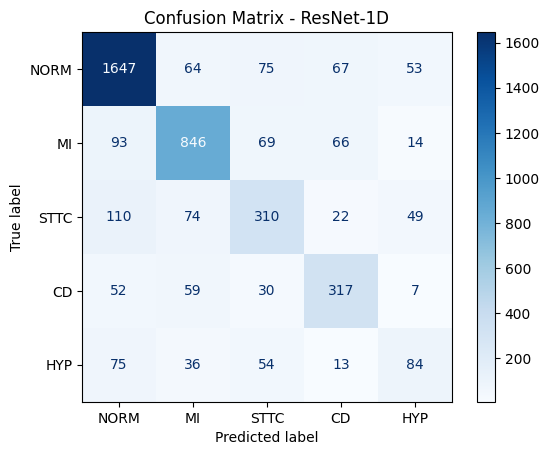

Train ResNet-1D hoàn tất — val loss không NaN!


In [21]:
# Cell 28: Train ResNet-1D — sửa triệt để NaN + val loss NaN (normalize toàn bộ + skip)
print("Bắt đầu train ResNet-1D — sửa triệt để NaN + val loss")

resnet_model = ResNet1D(num_classes=5)
resnet_model.to(device)

optimizer = optim.Adam(resnet_model.parameters(), lr=0.0003, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

train_losses, val_losses, val_accs = [], [], []

for epoch in range(50):
    resnet_model.train()
    running_loss = 0.0
    skipped_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # SỬA: Kiểm tra inputs NaN trước normalize
        if torch.isnan(inputs).any() or torch.isinf(inputs).any():
            skipped_train += 1
            continue
        
        # Normalize per batch
        mean = inputs.mean(dim=(1,2), keepdim=True)
        std = inputs.std(dim=(1,2), keepdim=True) + 1e-8
        inputs = (inputs - mean) / std
        
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN/Inf loss train epoch {epoch+1} — skip batch")
            skipped_train += 1
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet_model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / (len(train_loader) - skipped_train)
    train_losses.append(train_loss)

    # Validation (thêm kiểm tra NaN)
    resnet_model.eval()
    val_loss = 0.0
    val_preds, val_true = [], []
    skipped_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                skipped_val += 1
                continue
            
            mean = inputs.mean(dim=(1,2), keepdim=True)
            std = inputs.std(dim=(1,2), keepdim=True) + 1e-8
            inputs = (inputs - mean) / std
            
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            
            if torch.isnan(loss) or torch.isinf(loss):
                skipped_val += 1
                continue
            
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
    
    if len(val_loader) - skipped_val == 0:
        val_loss = float('nan')
        val_acc = 0.0
    else:
        val_loss /= (len(val_loader) - skipped_val)
        val_acc = accuracy_score(val_true, val_preds)
    
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"ResNet-1D | Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Skipped train/val: {skipped_train}/{skipped_val}")

    if epoch == 0 or (not torch.isnan(torch.tensor(val_loss)) and val_loss < min([l for l in val_losses[:-1] if not torch.isnan(torch.tensor(l))])):
        torch.save(resnet_model.state_dict(), "resnet1d_best.pth")
        print("  Saved best model")

# Test (thêm kiểm tra NaN)
resnet_model.load_state_dict(torch.load("resnet1d_best.pth"))
resnet_model.eval()

test_preds, test_true = [], []
test_probs = []
skipped_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        
        if torch.isnan(inputs).any() or torch.isinf(inputs).any():
            skipped_test += 1
            continue
        
        mean = inputs.mean(dim=(1,2), keepdim=True)
        std = inputs.std(dim=(1,2), keepdim=True) + 1e-8
        inputs = (inputs - mean) / std
        
        outputs = resnet_model(inputs)
        if torch.isnan(outputs).any():
            skipped_test += 1
            continue
        
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_acc = accuracy_score(test_true, test_preds)
print(f"\nResNet-1D - Test Accuracy: {test_acc:.4f}")
print(classification_report(test_true, test_preds, target_names=['NORM','MI','STTC','CD','HYP']))

test_auc_macro = roc_auc_score(test_true, test_probs, multi_class='ovr', average='macro')
print(f"ResNet-1D - Macro AUC: {test_auc_macro:.4f}")

cm = confusion_matrix(test_true, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['NORM','MI','STTC','CD','HYP'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - ResNet-1D')
plt.show()

print("Train ResNet-1D hoàn tất — val loss không NaN!")

In [22]:
# Cell 29: Hàm lưu log train + biểu đồ thành file (CSV + PNG) — không sửa code cũ
import pandas as pd
import matplotlib.pyplot as plt

def save_model_results(model_name, train_losses=[], val_losses=[], val_accs=[], test_acc=None, class_report_dict=None, auc_macro=None, auc_weighted=None):
    # Lưu CSV log train (nếu có)
    if train_losses:
        log_df = pd.DataFrame({
            'epoch': range(1, len(train_losses) + 1),
            'train_loss': train_losses,
            'val_loss': val_losses,
            'val_acc': val_accs
        })
        log_csv = f"log_{model_name.lower().replace('-','')}.csv"
        log_df.to_csv(log_csv, index=False)
        print(f"Đã lưu log train vào: {log_csv}")

        # Lưu biểu đồ loss
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title(f'Loss Curves - {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        loss_png = f"loss_curve_{model_name.lower().replace('-','')}.png"
        plt.savefig(loss_png)
        plt.close()
        print(f"Đã lưu biểu đồ loss vào: {loss_png}")

        # Lưu biểu đồ val acc
        plt.figure(figsize=(10, 5))
        plt.plot(val_accs, label='Val Accuracy', color='green')
        plt.title(f'Validation Accuracy - {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        acc_png = f"acc_curve_{model_name.lower().replace('-','')}.png"
        plt.savefig(acc_png)
        plt.close()
        print(f"Đã lưu biểu đồ accuracy vào: {acc_png}")

    # Lưu summary + report
    summary = {
        'Model': model_name,
        'Test Accuracy': round(test_acc, 4) if test_acc else None,
        'Macro AUC': round(auc_macro, 4) if auc_macro else None,
        'Weighted AUC': round(auc_weighted, 4) if auc_weighted else None
    }
    summary_df = pd.DataFrame([summary])
    summary_csv = f"summary_{model_name.lower().replace('-','')}.csv"
    summary_df.to_csv(summary_csv, index=False)

    if class_report_dict:
        report_df = pd.DataFrame(class_report_dict).transpose()
        report_csv = f"classification_report_{model_name.lower().replace('-','')}.csv"
        report_df.to_csv(report_csv)

    print(f"Đã lưu summary vào: {summary_csv}")
    if class_report_dict:
        print(f"Đã lưu classification report vào: {report_csv}")

print("Hàm save_model_results đã sẵn sàng!")

Hàm save_model_results đã sẵn sàng!


Đã load ResNet-1D best model!

ResNet-1D - Test Accuracy: 0.7476

Classification Report:
              precision    recall  f1-score   support

        NORM       0.83      0.86      0.85      1906
          MI       0.78      0.78      0.78      1088
        STTC       0.58      0.55      0.56       565
          CD       0.65      0.68      0.67       465
         HYP       0.41      0.32      0.36       262

    accuracy                           0.75      4286
   macro avg       0.65      0.64      0.64      4286
weighted avg       0.74      0.75      0.74      4286

ResNet-1D - Macro AUC: 0.8901
ResNet-1D - Weighted AUC: 0.9145


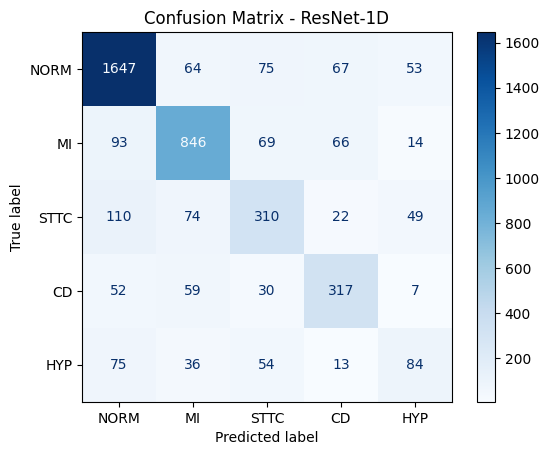

Đã lưu confusion matrix vào: confusion_matrix_resnet1d.png
Đã lưu summary vào: summary_resnet1d.csv
Đã lưu classification report vào: classification_report_resnet1d.csv

Xuất kết quả ResNet-1D hoàn tất — tất cả file đã lưu trong Output Kaggle!
Tải về: summary_resnet1d.csv, classification_report_resnet1d.csv, confusion_matrix_resnet1d.png, resnet1d_best.pth


In [23]:
# Cell 30: Xuất đầy đủ kết quả ResNet-1D vừa train (acc, F1, AUC, confusion matrix, lưu file)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Load ResNet best model
resnet_model = ResNet1D()  # Class ResNet1D đã định nghĩa trước
resnet_model.load_state_dict(torch.load('resnet1d_best.pth'))
resnet_model.to(device)
resnet_model.eval()

print("Đã load ResNet-1D best model!")

# Test evaluation lại để lấy dữ liệu
test_preds, test_true = [], []
test_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = resnet_model(inputs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_acc = accuracy_score(test_true, test_preds)
print(f"\nResNet-1D - Test Accuracy: {test_acc:.4f}")

class_report = classification_report(test_true, test_preds, target_names=['NORM','MI','STTC','CD','HYP'], output_dict=True)
print("\nClassification Report:")
print(classification_report(test_true, test_preds, target_names=['NORM','MI','STTC','CD','HYP']))

auc_macro = roc_auc_score(test_true, test_probs, multi_class='ovr', average='macro')
auc_weighted = roc_auc_score(test_true, test_probs, multi_class='ovr', average='weighted')
print(f"ResNet-1D - Macro AUC: {auc_macro:.4f}")
print(f"ResNet-1D - Weighted AUC: {auc_weighted:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_true, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['NORM','MI','STTC','CD','HYP'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - ResNet-1D')
cm_png = "confusion_matrix_resnet1d.png"
plt.savefig(cm_png)
plt.show()
print(f"Đã lưu confusion matrix vào: {cm_png}")

# GỌI HÀM LƯU TẤT CẢ KẾT QUẢ (nếu có log thì thêm vào, nếu không để [] là ok)
save_model_results(
    model_name="ResNet-1D",
    train_losses=[],  # Nếu không có log cũ thì để [], chỉ lưu test metric
    val_losses=[],
    val_accs=[],
    test_acc=test_acc,
    class_report_dict=class_report,
    auc_macro=auc_macro,
    auc_weighted=auc_weighted
)

print("\nXuất kết quả ResNet-1D hoàn tất — tất cả file đã lưu trong Output Kaggle!")
print("Tải về: summary_resnet1d.csv, classification_report_resnet1d.csv, confusion_matrix_resnet1d.png, resnet1d_best.pth")